In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/dr-datasets/output/1new/17169_left.jpeg
/kaggle/input/dr-datasets/output/1new/13170_left.jpeg
/kaggle/input/dr-datasets/output/1new/40447_right.jpeg
/kaggle/input/dr-datasets/output/1new/12589_left.jpeg
/kaggle/input/dr-datasets/output/1new/36055_right.jpeg
/kaggle/input/dr-datasets/output/1new/20412_right.jpeg
/kaggle/input/dr-datasets/output/1new/25458_right.jpeg
/kaggle/input/dr-datasets/output/1new/14883_left.jpeg
/kaggle/input/dr-datasets/output/1new/21110_right.jpeg
/kaggle/input/dr-datasets/output/1new/16515_right.jpeg
/kaggle/input/dr-datasets/output/1new/24867_right.jpeg
/kaggle/input/dr-datasets/output/1new/32130_right.jpeg
/kaggle/input/dr-datasets/output/1new/39791_left.jpeg
/kaggle/input/dr-datasets/output/1new/4077_right.jpeg
/kaggle/input/dr-datasets/output/1new/18736_right.jpeg
/kaggle/input/dr-datasets/output/1new/16065_right.jpeg
/kaggle/input/dr-datasets/output/1new/18210_left.jpeg
/kaggle/input/dr-datasets/output/1new/37500_left.jpeg
/kaggle/input/dr-d

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import cv2
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split
#from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import EfficientNetV2B0, ResNet152
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import (
       Dense, Dropout, Conv2D, BatchNormalization, Activation, Multiply, Add, GlobalAveragePooling2D, Reshape
)

### EXPLORATORY DATA ANALYSIS

In [5]:
input_base = "/kaggle/input/dr-datasets/output"
#input_base = "/dr-datasets/output"
folders = ["0new", "1new", "2new", "3new", "4new"]
image_counts = {}
total = 0
for folder in folders:
    folder_path = os.path.join(input_base, folder)
    
    if os.path.exists(folder_path):
        num_images = len(os.listdir(folder_path))
        image_counts[folder] = num_images
        total += len(os.listdir(folder_path))
    else:
        image_counts[folder] = 0  
for folder, count in image_counts.items():
    print(f"Total images in {folder}: {count}")
overall_total = sum(image_counts.values())
print(f"\nTotal number of images across all folders: {overall_total}")

Total images in 0new: 8526
Total images in 1new: 8929
Total images in 2new: 12687
Total images in 3new: 3386
Total images in 4new: 1587

Total number of images across all folders: 35115


In [6]:
for folder in folders:
    folder_path = os.path.join(input_base, folder)
    if os.path.exists(folder_path):
        num = len(os.listdir(folder_path))
        percentage = (num / total) * 100 if total > 0 else 0
        print(f"{folder}: {percentage:.2f}% images")
    else:
        print(f"{folder}: Folder not found")

0new: 24.28% images
1new: 25.43% images
2new: 36.13% images
3new: 9.64% images
4new: 4.52% images


### Splitting the Dataset

In [7]:
input_base = "/kaggle/input/dr-datasets/output"
output_base = "/kaggle/working/dataset_split"
train_dir = os.path.join(output_base, "train")
test_dir = os.path.join(output_base, "test")
val_dir = os.path.join(output_base, "val")
train_ratio = 0.7
val_ratio = 0.15  # 15%
test_ratio = 0.15  # 15%
folders_to_check = ["0new", "1new", "2new", "3new", "4new"]

In [52]:
def split_and_copy_files(src_folder, train_dst, test_dst, val_dst):
    images = os.listdir(src_folder)
    random.shuffle(images)  
    total_images = len(images)
    train_count = int(total_images * train_ratio)
    val_count = int(total_images * val_ratio)
    
    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]
    

    def copy_images(image_list, src, dst):
        os.makedirs(dst, exist_ok=True)
        for img in image_list:
            shutil.copy(os.path.join(src, img), os.path.join(dst, img))
    
    copy_images(train_images, src_folder, train_dst)
    copy_images(val_images, src_folder, val_dst)
    copy_images(test_images, src_folder, test_dst)
    print(f"Processed {src_folder}: Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")

In [9]:
for folder in folders_to_check:
    src_folder = os.path.join(input_base, folder)
    
    train_dst = os.path.join(train_dir, folder)
    test_dst = os.path.join(test_dir, folder)
    val_dst = os.path.join(val_dir, folder)
    
    if os.path.exists(src_folder):
        split_and_copy_files(src_folder, train_dst, test_dst, val_dst)
    else:
        print(f"Skipping {folder}, folder not found!")
print(os.listdir("/kaggle/working"))

Processed /kaggle/input/dr-datasets/output/0new: Train=5968, Val=1278, Test=1280
Processed /kaggle/input/dr-datasets/output/1new: Train=6250, Val=1339, Test=1340
Processed /kaggle/input/dr-datasets/output/2new: Train=8880, Val=1903, Test=1904
Processed /kaggle/input/dr-datasets/output/3new: Train=2370, Val=507, Test=509
Processed /kaggle/input/dr-datasets/output/4new: Train=1110, Val=238, Test=239
['dataset_split', '.virtual_documents']


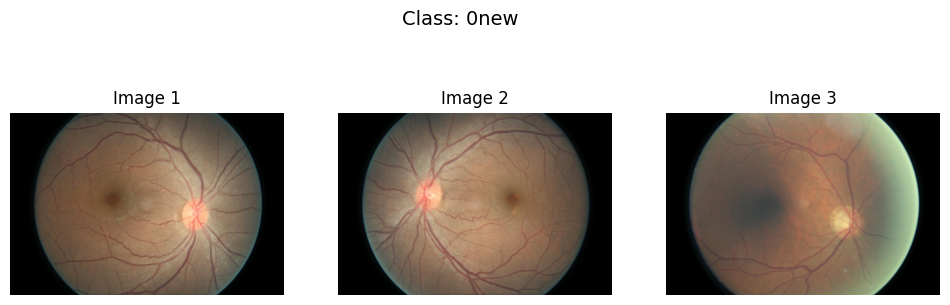

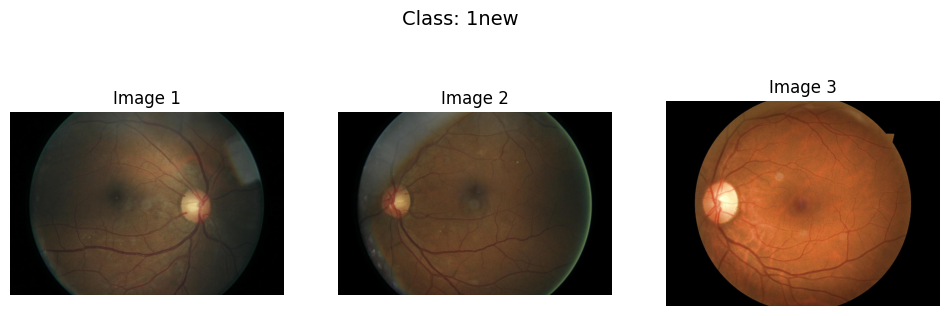

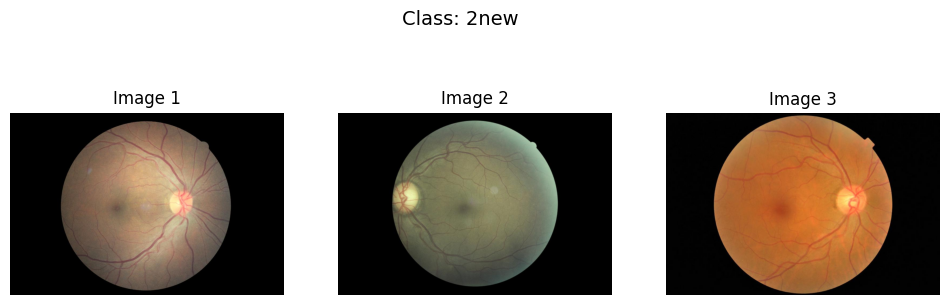

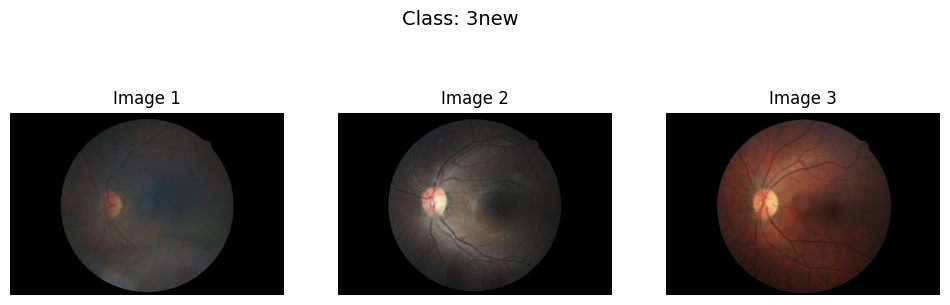

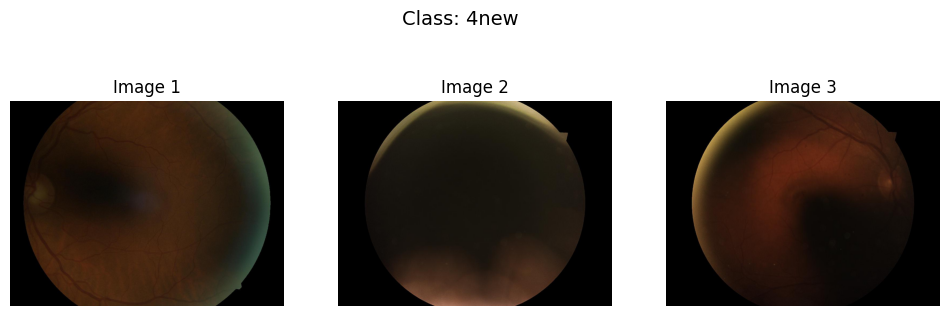

In [10]:
train_path = "/kaggle/working/dataset_split/train"
class_folders = sorted(os.listdir(train_path))
for class_folder in class_folders:
    class_path = os.path.join(train_path, class_folder)
    images = sorted(os.listdir(class_path))[:3]  # Get first 3 images

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(f"Class: {class_folder}", fontsize=14)

    for i, image_name in enumerate(images):
        img_path = os.path.join(class_path, image_name)
        img = cv2.imread(img_path)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB

        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"Image {i+1}")

    plt.show()

### Normalization

In [11]:
IMG_SIZE = (224, 224)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/dataset_split/train",
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode="categorical"
)

Found 24578 images belonging to 5 classes.


In [12]:
base_path = "/kaggle/working/dataset_split/train"
for folder in os.listdir(base_path):
    path = os.path.join(base_path, folder)
    print(f"{folder}: {len(os.listdir(path))} images")

0new: 5968 images
1new: 6250 images
2new: 8880 images
4new: 1110 images
3new: 2370 images


### Model Selection and Training

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input,
    rotation_range=20, zoom_range=0.2, horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input)
train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/dataset_split/train",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "/kaggle/working/dataset_split/val",
    target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

# Load Pretrained ResNet152 Model (Frozen)
base_model = tf.keras.applications.ResNet152(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.3)(x)
output_layer = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Found 24578 images belonging to 5 classes.
Found 5265 images belonging to 5 classes.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 59,552,645 (227.18 MB)

 Trainable params: 1,181,701 (4.51 MB)

 Non-trainable params: 58,370,944 (222.67 MB)

In [80]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    filepath="resnet152_model_without_FH.keras",  # Save the best model to this file
    monitor="val_loss",
    save_best_only=True,  # Save only when val_loss improves
    mode="min",
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,  
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.6107 - loss: 8.6016
Epoch 1: val_loss improved from inf to 3.35194, saving model to resnet152_model_without_FH.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 356s 216ms/step - accuracy: 0.6107 - loss: 8.6000 - val_accuracy: 0.6800 - val_loss: 3.3519
Epoch 2/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/30


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7518 - loss: 2.7367
Epoch 3: val_loss improved from 3.35194 to 1.63925, saving model to resnet152_model_without_FH.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 317s 206ms/step - accuracy: 0.7518 - loss: 2.7364 - val_accuracy: 0.7755 - val_loss: 1.6393
Epoch 4/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 20us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7778 - loss: 1.4671
Epoch 5: val_loss improved from 1.63925 to 1.10026, saving model to resnet152_model_without_FH.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 314s 204ms/step - accuracy: 0.7778 - loss: 1.4671 - val_accuracy: 0.7687 - val_loss: 1.1003
Epoch 6/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7910 - loss: 1.0008
Epoch 7: val_loss improved from 1.10026 to 0.86660, saving model to resnet152_model_without_FH.kera

In [81]:
# Get the best validation accuracy
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

Best Epoch: 11
Best Validation Accuracy: 80.91%


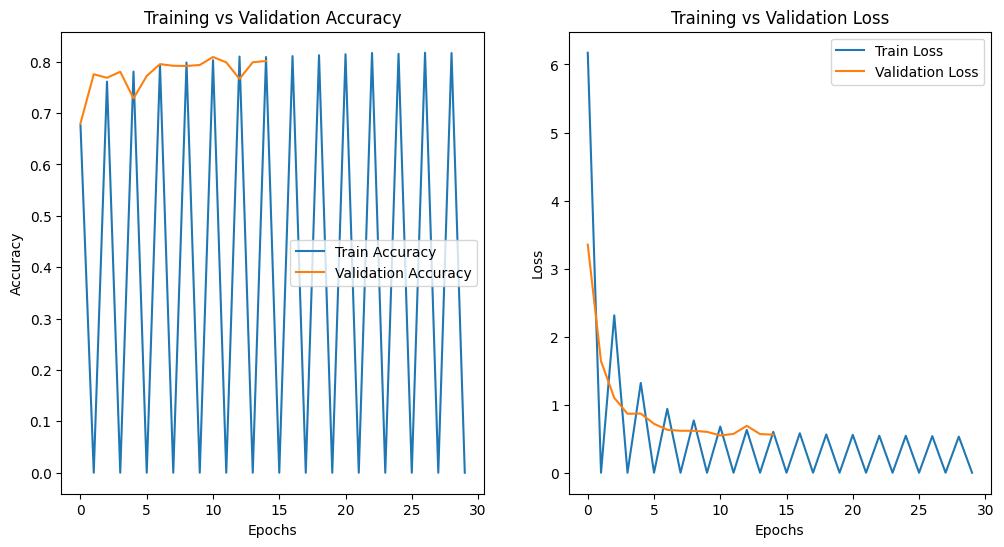

In [86]:
# Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [20]:

# from tensorflow.keras.applications import ResNet152
# from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.applications import ResNet152
# from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam

base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:100]:  
    layer.trainable = False  # Freeze first 100 layers
for layer in base_model.layers[100:]:  
    layer.trainable = True   # Unfreeze remaining layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  # Assuming 5 classes
model_resnet = Model(inputs=base_model.input, outputs=output)
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 59,584,901 (227.30 MB)

 Trainable params: 57,421,829 (219.05 MB)

 Non-trainable params: 2,163,072 (8.25 MB)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping]
)


Epoch 1/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 495s 245ms/step - accuracy: 0.5859 - loss: 11.1697 - val_accuracy: 0.7882 - val_loss: 4.0539
Epoch 2/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 3/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 324s 210ms/step - accuracy: 0.7975 - loss: 3.2021 - val_accuracy: 0.8266 - val_loss: 1.5506
Epoch 4/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 25us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 5/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 325s 210ms/step - accuracy: 0.8431 - loss: 1.2945 - val_accuracy: 0.7863 - val_loss: 1.1406
Epoch 6/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 36us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 7/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 329s 213ms/step - accuracy: 0.8542 - loss: 0.7655 - val_accuracy: 0.8672 - val_loss: 0.5927
Epoch 8/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 27us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00
Epoch 9/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 335s 217ms/step - accuracy: 0.869

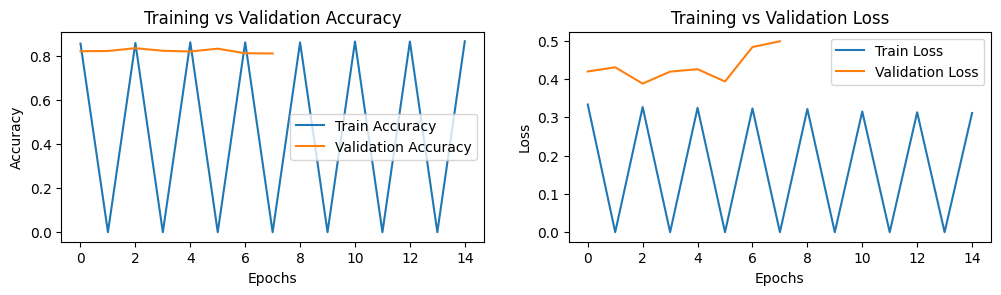

In [32]:
# Plot Training & Validation Accuracy/Loss
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [23]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

Best Epoch: 6
Best Validation Accuracy: 88.60%


In [26]:
model.save("/kaggle/working/resnet152_model.h5")
print("✅ ResNet152 Model Trained & Saved!")

✅ ResNet152 Model Trained & Saved!


In [27]:
base_model = EfficientNetV2B0(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)  # Apply pooling on output
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 Regularization
x = Dropout(0.3)(x)  # Additional Dropout layer
output = Dense(5, activation='softmax', kernel_regularizer=l2(0.01))(x)  # Output layer
model1 = Model(inputs=base_model.input, outputs=output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization) 

 Total params: 6,091,861 (23.24 MB)

 Trainable params: 6,031,253 (23.01 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("efficientnetv2b0_Without_FT.keras", monitor="val_loss", save_best_only=True, verbose=1)

# Train the model
history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8664 - loss: 0.4572
Epoch 1: val_loss improved from inf to 0.51733, saving model to efficientnetv2b0_Without_FT.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 314s 203ms/step - accuracy: 0.8664 - loss: 0.4572 - val_accuracy: 0.8285 - val_loss: 0.5173
Epoch 2/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8691 - loss: 0.4464
Epoch 2: val_loss improved from 0.51733 to 0.39931, saving model to efficientnetv2b0_Without_FT.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 321s 208ms/step - accuracy: 0.8691 - loss: 0.4464 - val_accuracy: 0.8805 - val_loss: 0.3993
Epoch 3/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8677 - loss: 0.4380
Epoch 3: val_loss did not improve from 0.39931
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 320s 207ms/step - accuracy: 0.8677 - loss: 0.4380 - val_accuracy: 0.7512 - val_loss: 0.7236
Epoch 4/50
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8774 - loss: 0.4124
Epoch 4: val_loss did no

In [33]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

Best Epoch: 2
Best Validation Accuracy: 88.05%


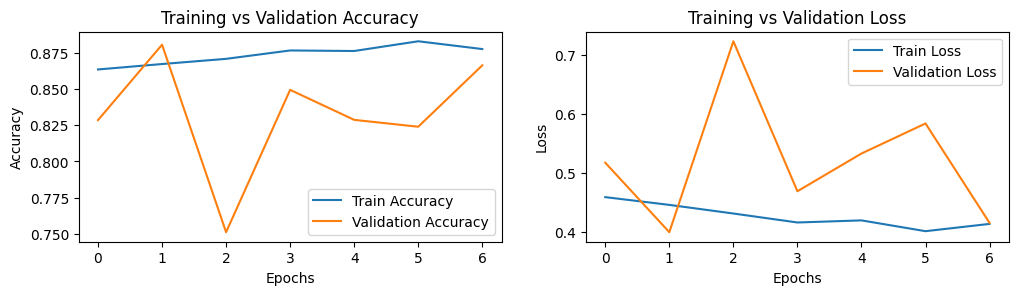

In [35]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(2, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(2, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [34]:
# Save the trained model in TensorFlow format
model1.save('/kaggle/working/efficientnetv2b0_model.h5')

print("EfficientNet Model trained and saved successfully")

EfficientNet Model trained and saved successfully


### Fine Tuning of EfficientNetV2

In [36]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
for layer in base_model.layers[-30:]:
    layer.trainable = True
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)
model1 = Model(inputs=base_model.input, outputs=output)
model1.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model1.summary() 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, None, None, 3)  │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, None, None, 3)  │              0 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, None, None, 32) │            864 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, None, None, 32) │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, None, None, 32) │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, None, None, 16) │          4,608 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, None, None, 16) │             64 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, None, None, 16) │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_conv       │ (None, None, None, 64) │          9,216 │ block1a_project_activ… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_bn         │ (None, None, None, 64) │            256 │ block2a_expand_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_expand_activation │ (None, None, None, 64) │              0 │ block2a_expand_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_conv      │ (None, None, None, 32) │          2,048 │ block2a_expand_activa… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2a_project_bn        │ (None, None, None, 32) │            128 │ block2a_project_conv[… │
│ (BatchNormalization) 

 Total params: 6,740,053 (25.71 MB)

 Trainable params: 6,679,445 (25.48 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5,  
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,   
    patience=3,  
    min_lr=1e-7
)

checkpoint = ModelCheckpoint(
    "efficientnetv2b0_With_FT.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

history = model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
  callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.6037 - loss: 2.3634
Epoch 1: val_loss improved from inf to 1.68042, saving model to efficientnetv2b0_With_FT.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 422s 227ms/step - accuracy: 0.6038 - loss: 2.3632 - val_accuracy: 0.8547 - val_loss: 1.6804 - learning_rate: 1.0000e-05
Epoch 2/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 44us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 3/30


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8640 - loss: 1.6641
Epoch 3: val_loss improved from 1.68042 to 1.65621, saving model to efficientnetv2b0_With_FT.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 311s 202ms/step - accuracy: 0.8640 - loss: 1.6641 - val_accuracy: 0.8551 - val_loss: 1.6562 - learning_rate: 1.0000e-05
Epoch 4/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 21us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 5/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8892 - loss: 1.5476
Epoch 5: val_loss improved from 1.65621 to 1.63257, saving model to efficientnetv2b0_With_FT.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 316s 205ms/step - accuracy: 0.8892 - loss: 1.5476 - val_accuracy: 0.8522 - val_loss: 1.6326 - learning_rate: 1.0000e-05
Epoch 6/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 15us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 7/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.8931 - loss

In [38]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

Best Epoch: 5
Best Validation Accuracy: 85.72%


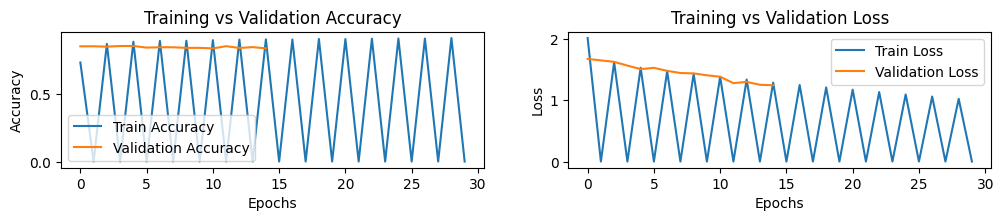

In [39]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(3, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(3, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [40]:
# Save the model after training
model1.save("/kaggle/working/efficientnetv2_model_Fine_Tuning.h5")  
print("EfficientNet Model after Fine Tuning is saved successfully")

EfficientNet Model after Fine Tuning is saved successfully


### CNN Deep Learning

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Flatten
model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01), input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  # Dropout to reduce overfitting
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  
    # Output Layer (5 classes, softmax activation)
    Dense(5, activation='softmax')
])
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,279,109 (84.99 MB)

 Trainable params: 22,278,661 (84.99 MB)

 Non-trainable params: 448 (1.75 KB)

In [45]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Validation set (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load training images
train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/dataset_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Load validation images
val_generator = val_datagen.flow_from_directory(
    "/kaggle/working/dataset_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 24578 images belonging to 5 classes.
Found 5265 images belonging to 5 classes.


In [46]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce Learning Rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

# Save the best model during training
checkpoint = ModelCheckpoint(
    "cnn.keras", 
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

# Train the model
history = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr, checkpoint]  # Add callbacks
)


Epoch 1/30
1536/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.4570 - loss: 9.1550
Epoch 1: val_loss improved from inf to 4.70423, saving model to cnn.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 318s 201ms/step - accuracy: 0.4570 - loss: 9.1528 - val_accuracy: 0.6044 - val_loss: 4.7042 - learning_rate: 1.0000e-04
Epoch 2/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 10us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/30
1536/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5134 - loss: 4.4068
Epoch 3: val_loss improved from 4.70423 to 2.72944, saving model to cnn.keras
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 304s 197ms/step - accuracy: 0.5134 - loss: 4.4062 - val_accuracy: 0.6429 - val_loss: 2.7294 - learning_rate: 1.0000e-04
Epoch 4/30
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/30
1536/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5605 - loss: 2.7879
Epoch 5: val_loss improved 

In [47]:
best_epoch = history.history['val_accuracy'].index(max(history.history['val_accuracy'])) + 1
best_val_acc = max(history.history['val_accuracy'])
print(f"Best Epoch: {best_epoch}")
print(f"Best Validation Accuracy: {best_val_acc * 100:.2f}%")

Best Epoch: 8
Best Validation Accuracy: 83.99%


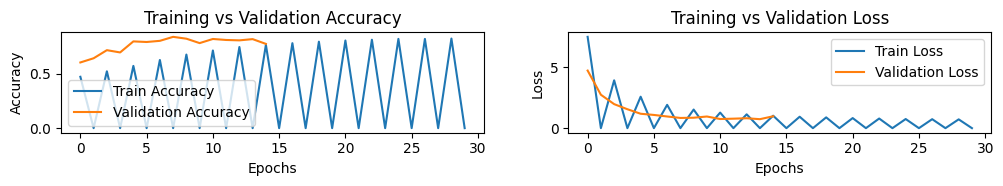

In [48]:
plt.figure(figsize=(12, 6))

# Accuracy Plot
plt.subplot(4, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(4, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()

In [56]:
model1.save("/kaggle/working/CNN.h5")  
print("CNN Model is saved successfully")

CNN Model is saved successfully


### Calculating the Ratio of the Splitting Dataset

In [58]:
train_folder = "/kaggle/working/dataset_split/train/"
val_folder = "/kaggle/working/dataset_split/val/"
test_folder = "/kaggle/working/dataset_split/test/"

# Function to count all images inside a directory (including subfolders)
def count_images_in_folder(folder_path):
    return sum([len(files) for _, _, files in os.walk(folder_path)])
train_images = count_images_in_folder(train_folder)
val_images = count_images_in_folder(val_folder)
test_images = count_images_in_folder(test_folder)
print(f"Total Train Images: {train_images}")
print(f"Total Validation Images: {val_images}")
print(f"Total Test Images: {test_images}")
print(f"Total Images in Dataset: {train_images + val_images + test_images}")

Total Train Images: 24578
Total Validation Images: 5265
Total Test Images: 5272
Total Images in Dataset: 35115


In [60]:
total_images = train_images + val_images + test_images
train_percent = (train_images / total_images) * 100
val_percent = (val_images / total_images) * 100
test_percent = (test_images / total_images) * 100
print(f"Total Train Images: {train_images} ({train_percent:.2f}%)")
print(f"Total Validation Images: {val_images} ({val_percent:.2f}%)")
print(f"Total Test Images: {test_images} ({test_percent:.2f}%)")
print(f"Total Images in Dataset: {total_images} (100%)")

Total Train Images: 24578 (69.99%)
Total Validation Images: 5265 (14.99%)
Total Test Images: 5272 (15.01%)
Total Images in Dataset: 35115 (100%)


In [50]:
IMG_SIZE = (224, 224)  
BATCH_SIZE = 16
# Use ImageDataGenerator to load test images
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input)
test_generator = test_datagen.flow_from_directory(
    "/kaggle/working/dataset_split/test",  # Update with your test folder path
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  
)

Found 5272 images belonging to 5 classes.


### Evaluation of the Model

In [63]:
model_paths = [
    "/kaggle/working/CNN.h5",
    "/kaggle/working/resnet152_model.h5",
    "/kaggle/working/efficientnetv2b0_Without_FT.keras",
    "/kaggle/working/efficientnetv2b0_model.h5"
]

for model_path in model_paths:
    model_name = os.path.basename(model_path)  
    print(f"\n🔍 Evaluating Model: {model_name}")
    model = load_model(model_path)
    # Compute test accuracy
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    print(f"✅ Test Accuracy for {model_name}: {test_acc * 100:.2f}%\n")


🔍 Evaluating Model: CNN.h5
330/330 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - accuracy: 0.2622 - loss: 4.9462
✅ Test Accuracy for CNN.h5: 14.26%


🔍 Evaluating Model: resnet152_model.h5
330/330 ━━━━━━━━━━━━━━━━━━━━ 33s 74ms/step - accuracy: 0.7837 - loss: 0.7751
✅ Test Accuracy for resnet152_model.h5: 64.87%


🔍 Evaluating Model: efficientnetv2b0_Without_FT.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.2519 - loss: 4.6851
✅ Test Accuracy for efficientnetv2b0_Without_FT.keras: 14.38%


🔍 Evaluating Model: efficientnetv2b0_model.h5
330/330 ━━━━━━━━━━━━━━━━━━━━ 25s 59ms/step - accuracy: 0.2519 - loss: 4.6851
✅ Test Accuracy for efficientnetv2b0_model.h5: 14.38%



In [82]:
model_paths = [
    "/kaggle/working/CNN.h5",
    "/kaggle/working/resnet152_model_without_FH.keras",
    "/kaggle/working/resnet152_model.h5",
    "/kaggle/working/efficientnetv2b0_Without_FT.keras",
    "/kaggle/working/efficientnetv2b0_model.h5"
]
model_names = []
test_accuracies = []
test_losses = []
for model_path in model_paths:
    model_name = os.path.basename(model_path)  
    print(f"\n🔍 Evaluating Model: {model_name}")
    
    model = load_model(model_path)
    test_loss, test_acc = model.evaluate(test_generator, verbose=1)
    model_names.append(model_name)
    test_accuracies.append(test_acc * 100)  # Convert to percentage
    test_losses.append(test_loss)

    print(f"✅ Test Accuracy for {model_name}: {test_acc * 100:.2f}%\n")


🔍 Evaluating Model: CNN.h5
330/330 ━━━━━━━━━━━━━━━━━━━━ 26s 60ms/step - accuracy: 0.2622 - loss: 4.9462
✅ Test Accuracy for CNN.h5: 14.26%


🔍 Evaluating Model: resnet152_model_without_FH.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 37s 77ms/step - accuracy: 0.7805 - loss: 0.7943
✅ Test Accuracy for resnet152_model_without_FH.keras: 63.77%


🔍 Evaluating Model: resnet152_model.h5
330/330 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.7837 - loss: 0.7751
✅ Test Accuracy for resnet152_model.h5: 64.87%


🔍 Evaluating Model: efficientnetv2b0_Without_FT.keras
330/330 ━━━━━━━━━━━━━━━━━━━━ 25s 57ms/step - accuracy: 0.2519 - loss: 4.6851
✅ Test Accuracy for efficientnetv2b0_Without_FT.keras: 14.38%


🔍 Evaluating Model: efficientnetv2b0_model.h5
330/330 ━━━━━━━━━━━━━━━━━━━━ 26s 61ms/step - accuracy: 0.2519 - loss: 4.6851
✅ Test Accuracy for efficientnetv2b0_model.h5: 14.38%



In [83]:
print(f"Test Accuracy is: {test_accuracies}")
print(f"Test Loss is: {test_losses}")

Test Accuracy is: [14.26403671503067, 63.77086639404297, 64.87101912498474, 14.377845823764801, 14.377845823764801]
Test Loss is: [9.844861030578613, 2.1491637229919434, 2.016335964202881, 10.071673393249512, 10.071673393249512]


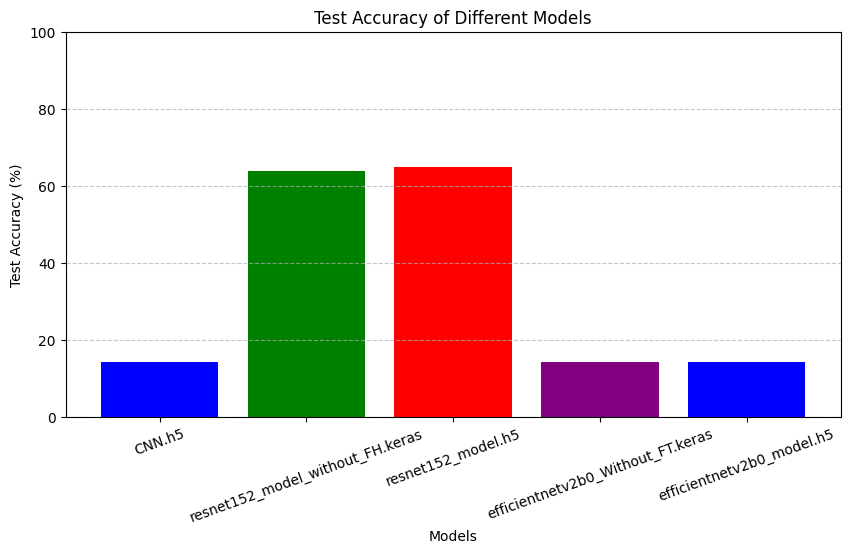

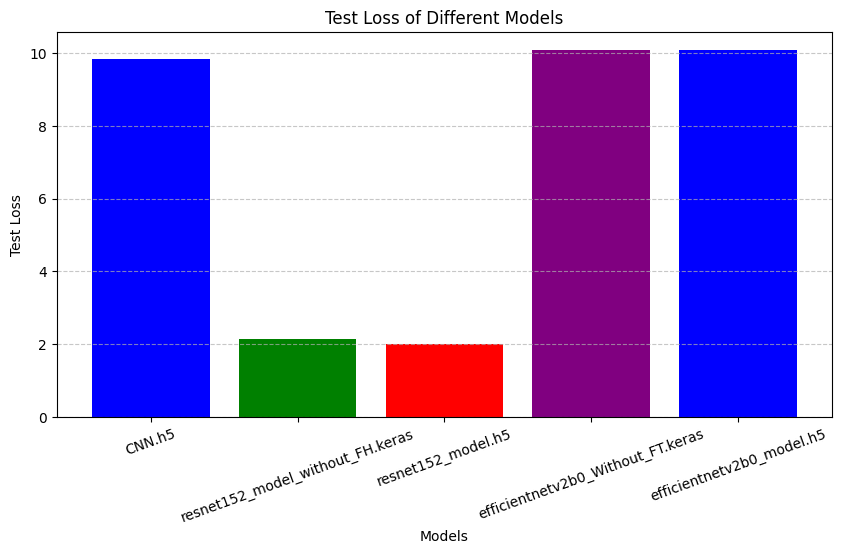

In [84]:
plt.figure(figsize=(10, 5))
plt.bar(model_names, test_accuracies, color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy of Different Models")
plt.xticks(rotation=20)
plt.ylim([0, 100])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(model_names, test_losses, color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Test Loss")
plt.title("Test Loss of Different Models")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


330/330 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step


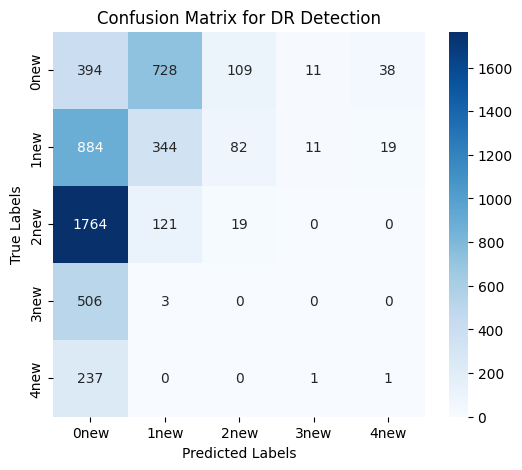

In [85]:
from sklearn.metrics import confusion_matrix, classification_report
true_labels = test_generator.classes  # Ground truth labels
# Get class names from the test generator
class_names = list(test_generator.class_indices.keys())  
# Get predicted probabilities from the model
pred_probs = model.predict(test_generator)
# Convert probabilities to class indices
pred_labels = np.argmax(pred_probs, axis=1)
# Compute the Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for DR Detection")
plt.show()

In [9]:

input_base = r"."
folders = ["0new", "1new", "2new", "3new", "4new"]

image_counts = {}
total = 0

for folder in folders:
    folder_path = os.path.join(input_base, folder)
    
    if os.path.exists(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
        image_counts[folder] = num_images
        total += num_images
    else:
        image_counts[folder] = 0

for folder, count in image_counts.items():
    print(f"Total images in {folder}: {count}")

overall_total = sum(image_counts.values())
print(f"\nTotal number of images across all folders: {overall_total}")


Total images in 0new: 8526
Total images in 1new: 8929
Total images in 2new: 12687
Total images in 3new: 3386
Total images in 4new: 1587

Total number of images across all folders: 35115
